# Analysis of the Osteoathritis Dataset with Pytorch and Fastai
Nikolas Wilhelm

<img src="./img/fastai.png" width="200">
<img src="./img/pytorch.png" width="200">
<img src="./img/osteo.jpg" width="200">

fastai:
https://www.fast.ai/

Pytorch:
https://pytorch.org/

Knee Osteoarthritis Severity Grading Dataset:
http://dx.doi.org/10.17632/56rmx5bjcr.1

## Import the relevant Libraries and Functions

In [12]:
import torch # Pytorch
from fastai.vision import * # The complete Fastai library
from fastai.metrics import error_rate # For Determining the accuracy

## Determine the (personal) path to the dataset

In [13]:
path = 'C:/Users/ga46yeg/data/KneeXrayData/ClsKLData/kneeKL224'

# 1. Create the Databunch
## Databunch contains training, validation and (optional) test sets.
They often come from a general folder:

In [14]:
data = ImageList.from_folder(path)

They require a "training" and "validation" set:

In [15]:
data = data.split_by_folder(valid='val')

They need to have labelsin order to perform classification tasks:

In [16]:
data = data.label_from_folder()

In order to generalise and be compatible the pictures will be transformed:
-tfms contains:
- Flip horicontally (left/right knee)
<img src="./img/flip.jpg" width = 100>
- Rotate by +/- 10 degrees
<img src="./img/rotate.png" width = 100>
- scale by 0.9 until 1.1
<img src="./img/scale.png" width = 100>

In [17]:
tfms = get_transforms()
data = data.transform(tfms)

The Lists are Transformed to the "databunch" class in order to be compatible for training

In [18]:
data = data.databunch()

The input will be normalized in order to improve performance.
As we will be using a "transfer learning" approach the normalization of the original dataset is used.

In [19]:
data = data.normalize(imagenet_stats)

Let's see the current state of our data

In [20]:
data

ImageDataBunch;

Train: LabelList (5778 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Valid: LabelList (826 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: C:\Users\ga46yeg\data\KneeXrayData\ClsKLData\kneeKL224;

Test: None

### Summarize the Creation of the DataBunch

In [25]:
tfms = get_transforms()
data = (
    ImageList.from_folder(path)
    .split_by_folder(valid='val')
    .label_from_folder()
    #.transform(tfms)
    .databunch()
    .normalize(imagenet_stats)
)

### Visualize a batch:

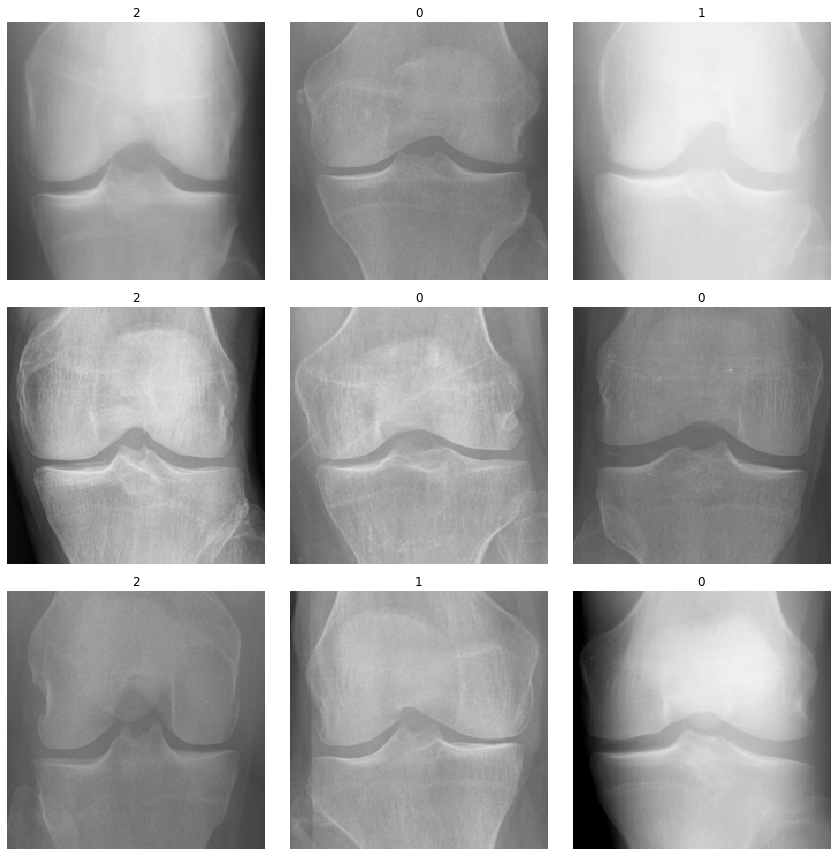

In [26]:
data.show_batch(rows=3)

# 2. Now it is time to define a Neural Network to Generate a "Learner"

### But which kind of network will be taken for Images?

<img src="./img/conv_nn.jpeg">

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.summary()

<img src="./img/resnet34.png">

In [ ]:
learn.fit_one_cycle(4) # train for 4 cycles
learn.save('./mini_train') # save the result

In [ ]:
learn = learn.load('./mini_train')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

# 3. Fine-tune

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# 4. Visualizing the activations

In [ ]:
idx=200
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
m = learn.model

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
xb.shape

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM (optional)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)